In [41]:
import numpy as np
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

Сгенерируем p-values и предположим, что мы их получили из множественной проверки гипотез.

In [17]:
np.random.seed(2)
pvals = np.random.uniform(0, 0.3, 100)

Посмотрим на их распределение:

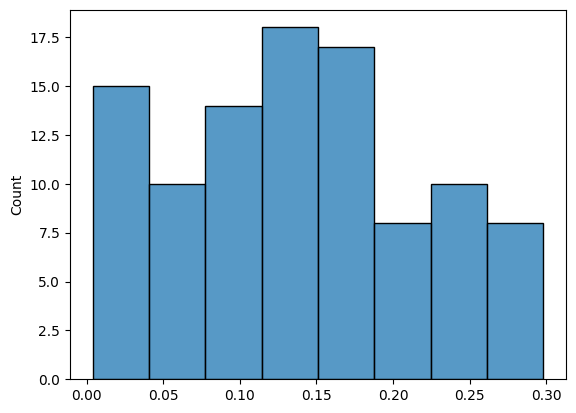

In [18]:
sns.histplot(pvals)
plt.show()

Скорректируем поправкой Холма:

In [19]:
pvals_corrected = multipletests(pvals, method="holm")

Посмотрим на результат: поправка сильно сдвинула среднее значения p_values.

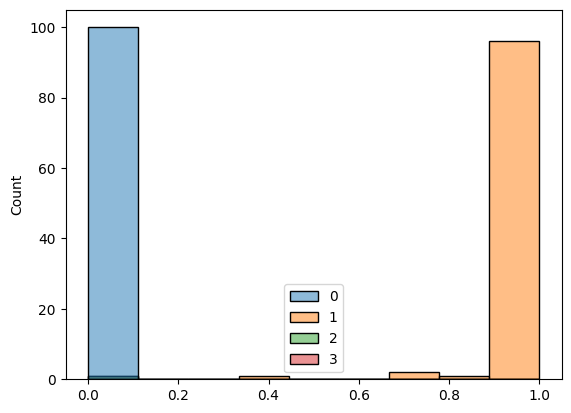

In [20]:
sns.histplot(pvals_corrected)
plt.show()

----
### Практика

In [21]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

In [22]:
df_train = pd.read_csv("./data/train.csv", index_col="PassengerId")
df_test = pd.read_csv("./data/test.csv", index_col="PassengerId")

In [23]:
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.00

In [24]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


-----
### ОТВЕТИМ НА ВОПРОСЫ С ТОЧКИ ЗРЕНИЯ СТАТИСТИКИ:

а) Правда ли, что мужчины реже выживали, чем женщины?

b) Верно ли, что погибшие в среднем были старше, чем выжившие?


In [33]:
# Ответ на вопрос а:
male_survived = df_train.query("Sex == 'male'")["Survived"].sum()
female_survived = df_train.query("Sex == 'female'")["Survived"].sum()

male_number = len(df_train.query("Sex == 'male'")["Survived"])
female_number = len(df_train.query("Sex == 'female'")["Survived"])

proportions_ztest(
    count=[male_survived, female_survived], nobs=[male_number, female_number]
)

(-16.218833930670097, 3.7117477701134797e-59)

Мы видим, что есть статистически значимое различие между числом выживших мужчин и женщин. Но наша цель не в том, чтобы зафиксировать наличие различий в уровне выживаемости, а выяснить, выживали ли мужчины реже. У нас есть два варианта: просто посмотреть, где больше выживших с учётом проверенной гипотезы, или провести одностороннюю проверку гипотезы. Последний вариант вполне подходит:

In [34]:
proportions_ztest(
    count=[male_survived, female_survived],
    nobs=[male_number, female_number],
    alternative="smaller",
)

(-16.218833930670097, 1.8558738850567398e-59)

In [40]:
# Ответ на вопрос б
# Здесь нам поможет тест на равенство средних:

df_cleared = df_train.dropna()

survived = df_cleared.query("Survived == 1")["Age"].values
not_survived = df_cleared.query("Survived == 0")["Age"].values

sp.stats.ttest_ind(survived, not_survived, alternative="greater")

TtestResult(statistic=-3.53435125095576, pvalue=0.9997405248346058, df=181.0)

Действительно, средний возраст погибших больше, чем средний возраст выживших.

___
### ПРОДОЛЖИМ РАБОТУ С ПАРАМЕТРОМ ВОЗРАСТА

Разобьём его на декады и проверим, верно ли, что выживаемость между различными возрастными группами различна. При этом помним, что мы с вами проводим множественную проверку гипотез:

In [49]:
# Преобразование возраста в возрастную группу
df_cleared["age_group"] = df_cleared["Age"] // 10

# Вычисление суммы выживших и общего числа пассажиров для каждой возрастной группы
group_sum_count = df_cleared.groupby("age_group")["Survived"].agg(["sum", "count"])

display(group_sum_count)

p_vals = []
coeffs = []
age_groups = group_sum_count.index
for i in range(len(age_groups)):
    for j in range(i + 1, len(age_groups)):
        age_group_1_sum, age_group_1_count = group_sum_count.loc[age_groups[i]]
        age_group_2_sum, age_group_2_count = group_sum_count.loc[age_groups[j]]
        p_value = proportions_ztest(
            count=[age_group_1_sum, age_group_2_sum],
            nobs=[age_group_1_count, age_group_2_count],
        )[1]
        p_vals.append(p_value)
        coeffs.append(age_groups[j])

p_vals_corrected = multipletests(p_vals, method="bonferroni")[1]

for i, pval in enumerate(p_vals_corrected):
    if pval < 0.05:
        print(coeffs[i])

,sum,count
age_group,,
0.0,8,10
1.0,15,19
2.0,27,36
3.0,37,49
4.0,19,33
5.0,13,24
6.0,3,9
7.0,0,2
8.0,1,1


Таким образом, в итоговую модель целесообразно включать пол и возраст. А добавление возрастных групп, напротив, выглядит сомнительно.

___

### Практика

In [55]:
# Задание 10.1
# Совпадает ли распределение целевой переменной в тренировочном и тестовом датасетах?
# Для проверки совпадения распределения целевой переменной в тренировочном и тестовом датасетах
# можно использовать статистические тесты на сходство распределений. Один из таких тестов - тест Колмогорова-Смирнова.

# Это вопрос с подвохом, ибо в тесте нет таргета

# Выполняем тест Колмогорова-Смирнова
ks_statistic, p_value = sp.stats.ks_2samp(df_train["Survived"], df_test["Survived"])

# Выводим результаты теста
alpha = 0.05
print(f"Статистика Колмогорова-Смирнова: {ks_statistic}")
print(f"P-значение: {p_value}")
if p_value > alpha:
    print(
        "Распределения целевой переменной в тренировочном и тестовом датасетах совпадают (не отвергаем нулевую гипотезу)"
    )
else:
    print(
        "Распределения целевой переменной в тренировочном и тестовом датасетах различаются (отвергаем нулевую гипотезу)"
    )

KeyError: 'Survived'

In [69]:
# Задание 10.2
# Какой p-value гипотезы о равенстве среднего возрастов в тренировочной и
# тестовой выборках? (ответ округлите до двух знаков после запятой)

train_age = df_train["Age"].dropna().values
test_age = df_test["Age"].dropna().values

sp.stats.ttest_ind(train_age, test_age)

TtestResult(statistic=-0.5987733746796555, pvalue=0.5494539128955762, df=1044.0)

In [81]:
# Задание 10.3
# Какой p-value гипотезы о равенстве доли мужчин в тренировочной и тестовой выборках?
# (ответ округлите до двух знаков после запятой)

male_train = df_train.query("Sex == 'male'").shape[0]
train_num = df_train.shape[0]

male_test = df_test.query("Sex == 'male'").shape[0]
test_num = df_test.shape[0]

proportions_ztest(count=[male_train, male_test], nobs=[train_num, test_num])

(0.39537787824896614, 0.6925640325233131)

In [85]:
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# Задание 10.4
# Как класс купленных мест связан с другими переменными?

• Средний возраст пассажиров всех трёх классов (Pclass) одинаковый (alpha=0.05)

• В первом классе (Pclass) больше мужчины, чем женщин (alpha=0.05)

• В среднем выжило больше пассажиров второго класса, чем всех остальных

• Выжило больше пассажиров, севших в порту Cherbourg (Embarked==С), чем в остальных

In [101]:
# Отметем очевидно не рабочие гипотезы

hipothesis_1 = df_train.groupby("Pclass").agg(
    {
        "Age": "mean",
        "Sex": lambda x: x.value_counts().to_dict(),
        "Survived": lambda x: x.value_counts().to_dict(),
    }
)

hipothesis_2 = df_train.groupby("Embarked").agg(
    {"Survived": lambda x: x.value_counts().to_dict()}
)

display(hipothesis_1, hipothesis_2)

,Age,Sex,Survived
Pclass,,,
1,38.233441,"{'male': 122, 'female': 94}","{1: 136, 0: 80}"
2,29.877630,"{'male': 108, 'female': 76}","{0: 97, 1: 87}"
3,25.140620,"{'male': 347, 'female': 144}","{0: 372, 1: 119}"


,Survived
Embarked,
C,"{1: 93, 0: 75}"
Q,"{0: 47, 1: 30}"
S,"{0: 427, 1: 217}"


Первая и последняя гипотезы очевидно отпадают сразу, остаются вторая и третья гипотезы.